In [67]:
import pandas as pd

In [68]:
model_df = pd.read_json('/home/edvard/Downloads/mag_papers_0/mag_subset.txt',lines=True)

In [69]:
model_df.shape

(10000, 19)

In [70]:
model_df.columns

Index(['abstract', 'authors', 'doc_type', 'doi', 'fos', 'id', 'issue',
       'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'publisher',
       'references', 'title', 'url', 'venue', 'volume', 'year'],
      dtype='object')

In [71]:
model_df = model_df[model_df.lang == 'en'].drop_duplicates(subset='title', keep='first').drop(['doc_type', 
                                                                                                   'doi', 'id', 
                                                                                                   'issue', 'lang', 
                                                                                                   'n_citation', 
                                                                                                   'page_end', 
                                                                                                   'page_start', 
                                                                                                   'publisher', 
                                                                                                   'references',
                                                                                                   'url', 'venue', 
                                                                                                   'volume'], axis=1)

model_df.shape

(5167, 6)

In [72]:
model_df.head(4)

,abstract,authors,fos,keywords,title,year
0,A system and method for maskless direct write ...,NaN,"[Electronic engineering, Computer hardware, En...",NaN,System and Method for Maskless Direct Write Li...,2015
1,NaN,[{'name': 'Ahmed M. Alluwaimi'}],"[Biology, Virology, Immunology, Microbiology]","[paratuberculosis, of, subspecies, proceedings...",The dilemma of the Mycobacterium avium subspec...,2016
2,NaN,"[{'name': 'Jovana P. Lekovich', 'org': 'Weill ...",NaN,NaN,Should endometriosis be an indication for intr...,2015
5,NaN,[{'name': 'George C. Sponsler'}],NaN,NaN,"Should APS Discuss Public Issues: Direct, pers...",1968


In [111]:
def feature_array(x, unique_array):
    row_dict = {}
    for i in x.index:
        var_dict = {}
        
        for j in range(len(unique_array)):
            if type(x[i]) is list:
                if unique_array[j] in x[i]:
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
            else:    
                if unique_array[j] == str(x[i]):
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
        
        row_dict.update({i : var_dict})
    
    feature_df = pd.DataFrame.from_dict(row_dict).T
    
    return feature_df

In [112]:
unique_fos = sorted(list({ feature
                          for paper_row in model_df.fos.fillna('0')
                          for feature in paper_row }))

unique_year = sorted(model_df['year'].astype('str').unique())

In [113]:
year_features = feature_array(model_df['year'], unique_year)


In [114]:
fos_features = feature_array(model_df['fos'], unique_fos)

In [115]:
%time first_feature = fos_features.join(year_features).T

CPU times: user 548 ms, sys: 204 ms, total: 752 ms
Wall time: 696 ms


In [116]:
from sys import getsizeof
print('Size of first feature array: ', getsizeof(first_feature))

Size of first feature array:  200794768


In [117]:
first_feature.shape

(4849, 5167)

In [118]:
from scipy.spatial.distance import cosine

def item_collab_filter(features_df):
    item_similarities = pd.DataFrame(index = features_df.columns, columns = features_df.columns)
    
    for i in features_df.columns:
        for j in features_df.columns:
            item_similarities.loc[i][j] = 1 - cosine(features_df[i], features_df[j])
    
    return item_similarities

In [119]:
%time first_items = item_collab_filter(first_feature.loc[:, 0:1000])


CPU times: user 1min 30s, sys: 11.8 ms, total: 1min 30s
Wall time: 1min 31s


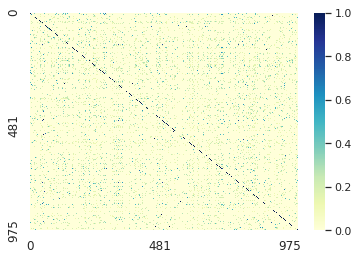

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

sns.set()
ax = sns.heatmap(first_items.fillna(0), 
                 vmin=0, vmax=1, 
                 cmap="YlGnBu", 
                 xticklabels=250, yticklabels=250)
ax.tick_params(labelsize=12)

In [121]:
def paper_recommender(paper_index, items_df):
    print('Based on the paper: \nindex = ', paper_index)
    print(model_df.iloc[paper_index])
    top_results = items_df.loc[paper_index].sort_values(ascending=False).head(4)
    print('\nTop three results: ') 
    order = 1
    for i in top_results.index.tolist()[-3:]:
        print(order,'. Paper index = ', i)
        print('Similarity score: ', top_results[i])
        print(model_df.iloc[i], '\n')
        if order < 5: order += 1

In [123]:
paper_recommender(2, first_items)

Based on the paper: 
index =  2
abstract                                                  NaN
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                       NaN
keywords                                                  NaN
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object

Top three results: 
1 . Paper index =  2
Similarity score:  1.0
abstract                                                  NaN
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                       NaN
keywords                                                  NaN
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object 

2 . Paper index =  292
Similarity score:  1.0
abstract                                                  NaN
aut

In [124]:
print("Year spread: ", model_df['year'].min()," - ", model_df['year'].max())

Year spread:  1831  -  2017


In [125]:
print("Quantile spread:\n", model_df['year'].quantile([0.25, 0.5, 0.75]))

Quantile spread:
 0.25    1990.0
0.50    2005.0
0.75    2012.0
Name: year, dtype: float64


In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [127]:
%matplotlib inline

Text(0, 0.5, 'Occurrence')

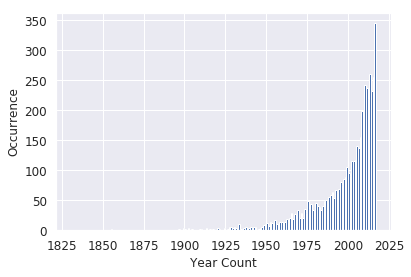

In [128]:
# plot years to see the distribution
fig, ax = plt.subplots()
model_df['year'].hist(ax=ax, bins= model_df['year'].max() - model_df['year'].min())
ax.tick_params(labelsize=12)
ax.set_xlabel('Year Count', fontsize=12)
ax.set_ylabel('Occurrence', fontsize=12)

In [129]:
# binning here (by 10 years)
bins = int(round((model_df['year'].max() - model_df['year'].min()) / 10))

temp_df = pd.DataFrame(index = model_df.index)
temp_df['yearBinned'] = pd.cut(model_df['year'].tolist(), bins, precision = 0)

X_yrs = pd.get_dummies(temp_df['yearBinned'])
X_yrs.columns.categories

IntervalIndex([(1831.0, 1841.0], (1841.0, 1851.0], (1851.0, 1860.0], (1860.0, 1870.0], (1870.0, 1880.0] ... (1968.0, 1978.0], (1978.0, 1988.0], (1988.0, 1997.0], (1997.0, 2007.0], (2007.0, 2017.0]],
              closed='right',
              dtype='interval[float64]')

Text(0, 0.5, 'Counts')

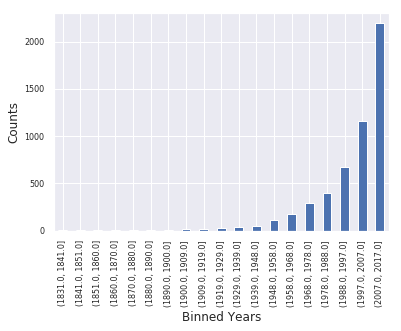

In [130]:
fig, ax = plt.subplots()
X_yrs.sum().plot.bar(ax = ax)
ax.tick_params(labelsize=8)
ax.set_xlabel('Binned Years', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

In [131]:
X_fos = fos_features.values